In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import qutip
from copy import deepcopy
from CoupledQuantumSystems.systems import FluxoniumOscillatorSystem
from CoupledQuantumSystems.drive import DriveTerm,square_pulse_with_rise_fall
from CoupledQuantumSystems.evo_parrallel import run_parallel_ODEsolve_and_post_process_jobs_with_different_systems

In [3]:
max_ql = 25
max_ol = 200
EJ = 4
EC = EJ/2.0
EL = EJ/30
Er = 13.63285461

g = 0.3
w_d = 13.6355
amp = 0.01
kappa = 2e-3

tot_time =500
tlist = np.linspace(0, tot_time, tot_time)
# system  =  FluxoniumOscillatorSystem(
#                 EJ = EJ,
#                 EC = EC,
#                 EL = EL,
#                 Er = Er,
#                 g_strength = g,
#                 kappa=kappa,
#                 qubit_level = max_ql,
#                 osc_level = max_ol,
#                 products_to_keep=[[ql, ol] for ql in range(max_ql) for ol in range(max_ol) ],
#                 computaional_states = '0,2',
#                 )

# with open('gf_mcsolve_system_g3a01k002.pkl', 'wb') as f:
#     pickle.dump(system,f)

In [4]:

with open('gf_mcsolve_system_g3a01k002.pkl', 'rb') as f:
    system = pickle.load(f)

# 2 store the mcsolve jobs

In [4]:
# state_leak_dressed = qutip.basis(max_ql * max_ol, system.product_to_dressed[(1,0)])
state_0_dressed = qutip.basis(max_ql * max_ol, system.product_to_dressed[(0,0)])
state_1_dressed = qutip.basis(max_ql * max_ol, system.product_to_dressed[(2,0)])
state_plus_X_dressed = (state_0_dressed +  state_1_dressed).unit()
state_minus_X_dressed = (state_0_dressed - state_1_dressed).unit()
state_plus_Y_dressed = (state_0_dressed + 1j * state_1_dressed).unit()
state_minus_Y_dressed = (state_0_dressed - 1j * state_1_dressed).unit()

initial_states  = [
                    # state_leak_dressed,
                   state_0_dressed,
                   state_1_dressed,
                   state_plus_X_dressed,
                   state_minus_X_dressed,
                   state_plus_Y_dressed,
                   state_minus_Y_dressed
                   ]

# leakage_products_to_keep = [[ql, ol] for ql in [1] for ol in range(max_ol) ]
computational_products_to_keep = [[ql, ol] for ql in range(10) for ol in range(100) ]
list_of_products_to_keep = [
    # leakage_products_to_keep,
    computational_products_to_keep,
    computational_products_to_keep,
    computational_products_to_keep,
    computational_products_to_keep,
    computational_products_to_keep,
    computational_products_to_keep
]

# list_of_systems = []
# list_of_kwargs = []
# for products_to_keep, y0 in zip(list_of_products_to_keep, initial_states):
#     system.set_new_product_to_keep(products_to_keep)
#     system.set_new_operators_after_setting_new_product_to_keep()
#     list_of_systems.append(deepcopy(system))
#     list_of_kwargs.append( {
#         'y0':system.truncate_function(y0) ,
#         'tlist':tlist,
#         'drive_terms':[DriveTerm( 
#                             driven_op= system.driven_operator,
#                             pulse_shape_func=square_pulse_with_rise_fall,
#                             pulse_shape_args={
#                                 'w_d': w_d ,
#                                 'amp': amp,
#                                 't_rise': 20,
#                                 't_square': tot_time
#                             })],
#         'e_ops':[system.a_trunc , system.a_trunc.dag()*system.a_trunc],
#         # 'c_ops':[kappa *qutip.lindblad_dissipator(system.a_trunc) ]
#         })
    

# results = run_parallel_ODEsolve_and_post_process_jobs_with_different_systems(
#     list_of_systems,
#     list_of_kwargs,
#     post_processing = ['pad_back']
# )

# import pickle
# with open('sesolve_large_dim_a01_tomo.pkl', 'wb') as file:
#     pickle.dump(results, file)


In [5]:
import pickle
with open('sesolve_large_dim_a01_tomo.pkl', 'rb') as file:
    results = pickle.load(file)


In [6]:
from functools import partial
import multiprocessing
from tqdm import tqdm
from CoupledQuantumSystems.qobj_manip import find_dominant_frequency,get_product_vectorized,dressed_to_product_vectorized

def convert_dressed_to_product_vectorized(system, states, products_to_keep, num_processes=None, update_products_to_keep=True):
    if update_products_to_keep:
        system.set_new_product_to_keep(products_to_keep)
        system.set_new_operators_after_setting_new_product_to_keep()

    if num_processes is None:
        num_processes = multiprocessing.cpu_count()

    # Multiprocessing, vectorized
    partial_function = partial(get_product_vectorized,
                               pad_back_custom=system.pad_back_function,
                               product_to_dressed=system.product_to_dressed,
                               sign_multiplier_vector=system.sign_multiplier_vector)

    with multiprocessing.Pool(processes=num_processes) as pool:
        # Wrap tqdm around the iterator to show the progress
        product_states = list(tqdm(pool.imap(partial_function, states), total=len(states), desc="Processing States"))

    return product_states


# for i, (result, products_to_keep) in enumerate(zip(results, list_of_products_to_keep)):
#     result.states_in_product_basis = convert_dressed_to_product_vectorized(system=system, 
#                                                                            states= result.states,
#                                                                             products_to_keep = products_to_keep,
#                                                                             num_processes = 18
#                                                                                     )
# with open('sesolve_large_dim_a015_tomo_product.pkl', 'wb') as f:
#     pickle.dump(results,f)


for i, result, products_to_keep in zip([0,1,2,3,4,5][2:],results[2:], list_of_products_to_keep[2:]):
    states_in_product_basis = convert_dressed_to_product_vectorized(system=system, 
                                                                           states= result.states,
                                                                            products_to_keep = products_to_keep,
                                                                            num_processes = 14
                                                                                    )
    with open(f'sesolve_large_dim_a015_tomo_product_part{i}.pkl', 'wb') as f:
        pickle.dump(states_in_product_basis,f)

Processing States: 100%|██████████| 500/500 [02:38<00:00,  3.16it/s]


t loop: 100%|██████████| 500/500 [00:12<00:00, 39.95it/s]


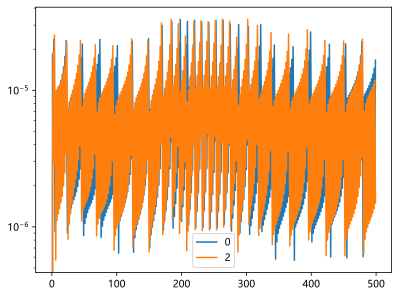

In [10]:
leakage_arr = np.zeros(shape=(2,len(tlist)))
for i,ql in zip([0,1],[0,2]):
    initial_qbt_state = qutip.basis(max_ql,  ql)
    op = initial_qbt_state * initial_qbt_state.dag()
    with open(f'sesolve_large_dim_a015_tomo_product_part{i}.pkl', 'rb') as f:
        states_in_product_basis = pickle.load(f)
    for t_idx in tqdm(range(len(tlist)), desc = "t loop"):
        rho_product = states_in_product_basis[t_idx]
        rho_qbt = qutip.Qobj(np.array(rho_product.ptrace(0)))
        leakage_arr[i,t_idx] = 1-qutip.expect(op, rho_qbt)

plt.plot(leakage_arr[0],label=f'{0}')
plt.plot(leakage_arr[1],label=f'{2}')

plt.legend()
plt.yscale('log')

In [6]:
for i, result in zip([0,1,2,3,4,5],results):
    with open(f'sesolve_large_dim_a015_tomo_product_part{i}.pkl', 'rb') as f:
        states_in_product_basis = pickle.load(f)
    result.states_in_product_basis = states_in_product_basis

In [14]:
def truncate_to_computational(state,i,j):
    arr = state.full()
    arr= arr[[i, j], :][:, [i, j]]
    dm = qutip.Qobj(arr)
    dm = dm/dm.tr()
    return dm
zero = qutip.basis(2, 0)
one = qutip.basis(2, 1)
states_ideal  = [zero,
                one,
                (zero +  one).unit(),
                (zero - one).unit(),
                (zero + 1j * one).unit(),
                (zero - 1j *one).unit()]

def calc_average_fidelity_with_phase(phase,dms,states_ideal):
    gate = qutip.qip.operations.phasegate(phase)
    fid=[]
    for dm,ket_ideal in zip(dms,states_ideal):
        fid.append(qutip.fidelity(gate*dm*gate.dag(), ket_ideal))
    return 1-sum(fid)/len(fid)


Processing: 100%|██████████| 500/500 [01:22<00:00,  6.07it/s]


Text(0.5, 1.0, 'infidelity')

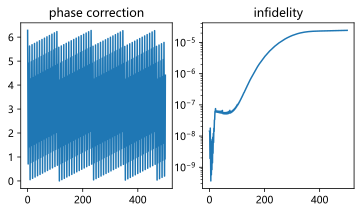

In [15]:
from scipy.optimize import minimize
infidelity = []
phase = []
original_phase = 2*np.pi*tlist*(system.evals[system.product_to_dressed[(2,0)]]-system.evals[system.product_to_dressed[(0,0)]]) + np.pi
original_phase = original_phase % (2*np.pi) 

for idx in tqdm(range(len(tlist)), desc='Processing'):
    dms = [truncate_to_computational(result.states_in_product_basis[idx].ptrace(0), 0,2) for result in results]
    def objective_function(phase):
        return calc_average_fidelity_with_phase(phase[0], dms, states_ideal)
    opt_result = minimize(objective_function,x0=  [original_phase[idx]],bounds = [(0, 2*np.pi)], method="Powell")
    infidelity.append(opt_result.fun)
    phase.append(opt_result.x[0])
    
fig, axes = plt.subplots(1,2,figsize = (6,3))
axes[0].plot(tlist,phase)
axes[0].set_title('phase correction')
axes[1].plot(tlist,infidelity)
axes[1].set_yscale('log')
axes[1].set_title('infidelity')


In [16]:
with open(f'sesolve_large_dim_a015_tomo_infidelity.pkl', 'wb') as f:
    pickle.dump(infidelity,f)

In [10]:
leakage_arr = np.zeros(shape=(6,len(tlist)))
initial_qbt_state = qutip.basis(max_ql,  0)
op = initial_qbt_state * initial_qbt_state.dag()
for i in [0,1,2,3,4,5]:
    for t_idx in tqdm(range(len(tlist)), desc = "t loop"):
        rho_product = results[i].states_in_product_basis[t_idx]
        rho_qbt = qutip.Qobj(np.array(rho_product.ptrace(0)))
        leakage_arr[i,t_idx] = 1-qutip.expect(op, rho_qbt)

t loop: 100%|██████████| 500/500 [00:04<00:00, 123.28it/s]


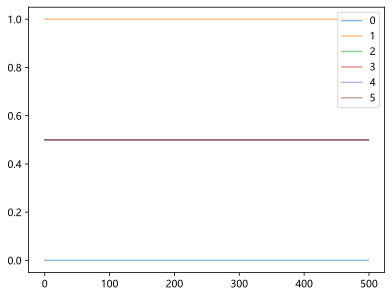

In [12]:
for i in [0,1,2,3,4,5]:
    plt.plot(leakage_arr[i],label=f'{i}',alpha=0.5)
plt.legend()
# plt.yscale('log')